# Decision Tree Classifier - Feature Importance

### Theory 

A key strength of decision trees are that they are considered to be white box models, meaning that their predictions are highly interpretable. Quantifying feature importance, which features explain the most variance in the data, is straight-forward with decision trees. Intuitively, the most important features should show up more often in decisions compared to less important ones. Moreover, these more important features should also decrease the impurity of the data to greater extent. That is, the difference in impurity between the parent node containing the decision and the children nodes should be larger. These two expected observations leads us to quantity the importance of a feature $\mathcal{I}_j$ as,  

$$\mathcal{I}_j = \sum_{m \in F_j} P_{\int, m} \Delta G_{m}$$

In which, $F_j$ are the set of incides that label the nodes which have decisions involving the feature $j$, $\Delta G_{m} = G_{P} - G_{C} > 0$ is the decrease in Gini index from the parents to the children node (we can replace this with any metric that quantifies node impurity) and $P_{\int, m}$ is the probability that a random data point $X_i$ taken from the dataset which reach the given node $m$. Let us apply this formula into practice, consider the following decision tree below,

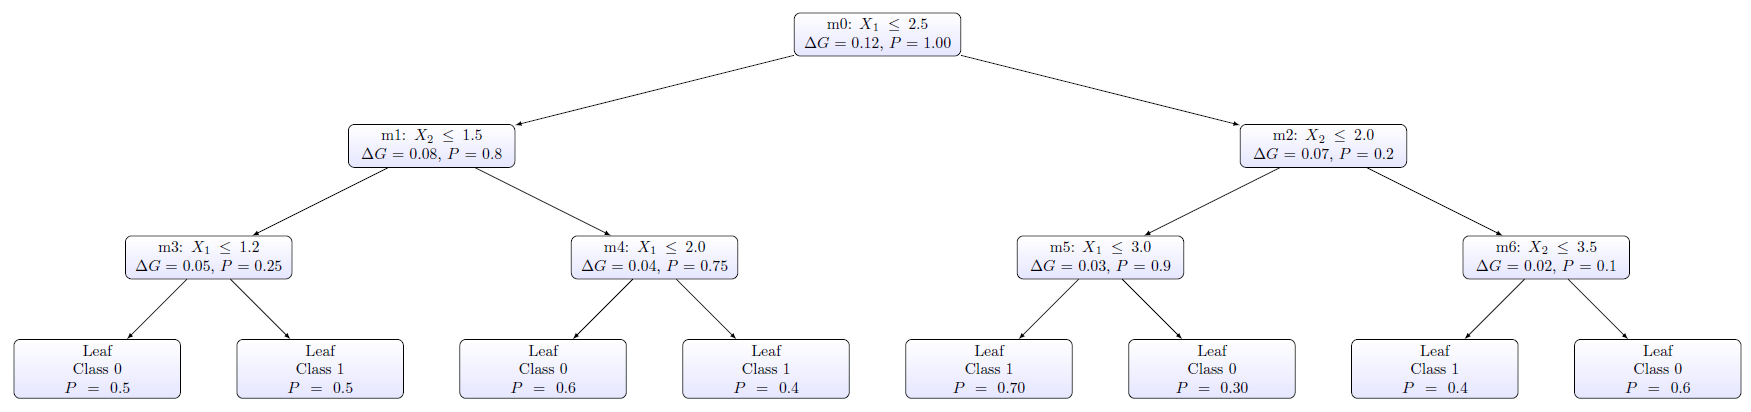


In this case, our data points have two features $j \in [1, 2]$ such that $X_{ij} = [X_{i1}, X_{i2}]$. We also only have two classes, $C=0$ and $C=1$. Let us compute the importance $\mathcal{I}_1$ of the first feature. First we identify all the paths,

$\mathcal{I}_1 = P_{0 \rightarrow 1 \rightarrow 3}\Delta G_{3} + P_{0 \rightarrow 1 \rightarrow 4}\Delta G_{4} + P_{0 \rightarrow 2 \rightarrow 5}\Delta G_{5}$

Computation of the probabilies is the next step,

$\mathcal{I}_1 = (1)(0.8)(0.25)\Delta G_{3} + (1)(0.8)(0.75)\Delta G_{4} + (1)(0.2)(0.9)\Delta G_{5}$

Assuming that already have $\Delta G_{m}$ for all nodes $m$, we can finish our calculation,

$\mathcal{I}_1 = (1)(0.8)(0.25)(0.05) + (1)(0.8)(0.75)(0.04) + (1)(0.2)(0.9)(0.03) = 0.0394$

Note that the probability $P$ associated with each node reflects the likelihood of that node being traversed, given that the data point has already arrived at its parent. We do the same computation for the importance $\mathcal{I}_2$ of the second feature, 

$\mathcal{I}_2 = P_{0 \rightarrow 1}\Delta G_{1} + P_{0 \rightarrow 2}\Delta G_{2} + P_{0 \rightarrow 2 \rightarrow 6}\Delta G_{6} = 0.0784 $

In practice, we normalise the importances since their values are dependent upon the scale in the dataset. In doing so, we ensure that the sum of all normalised importances is such that $\sum_{j} \bar{\mathcal{I}}_j = 1$.

$$\bar{\mathcal{I}}_j = \frac{\sum_{m \in F_j} P_{\int, m} \Delta G_{m}}{\sum_{j}^{M} \mathcal{I}_j}$$

### Recursive Algoritm

In [ ]:
# Importing,
import copy
import numpy as np

class DecisionTreeClassifier():
    """This class implements a DecisionTreeClassifier using the CART algorithm with the functionality of NumPy."""

    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.tree_root = None, None, None

        # Importance vector,
        self.importances = None

        # Stopping criteria,
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        return None

    def fit(self, X, y):
        """Use this method to fit the tree to the training dataset."""

        # Assignment to class attributes,
        self.X, self.y = X, y

        # Growing the tree,
        self.tree_root = self._grow_tree(X=X, y=y, node_label="O", current_depth=0) # <-- The label "O" is for the root node.

        return None

    def predict(self, X):
        """Wrapper method around _traverse_tree() for predictions."""

        # Traversing the tree,
        preds = np.asarray([self._traverse_tree(x, self.tree_root) for x in X]) # <-- Starting at the root node.

        return preds

    def score(self, X, y):
        """Computes the accuracy of the model on the given testing data."""

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing accuracy,
        accuracy = np.sum(y == y_preds)/len(y)

        return accuracy

    def print_tree(self, structural=True):
        """Prints the structure of the tree using _traverse_tree_print which traverses the tree."""
        n_nodes = self._traverse_tree_print(node=self.tree_root, structural=structural)
        print(f"Number of nodes: {n_nodes}")
        return None

    def prune(self, alpha, inplace=True):
        """Calling this function allows for cost-complexity pruning."""

        if inplace:
            self._compute_cpp_info(node=self.tree_root)
            self._prune_tree(node=self.tree_root, alpha=alpha)
            return None
        else:
            clone_tree = copy.deepcopy(self) # <-- Copy of the tree is created.
            self._compute_cpp_info(node=clone_tree.tree_root)
            self._prune_tree(node=clone_tree.tree_root, alpha=alpha)
            return clone_tree
        
    def compute_importances(self):
        """Call this function returns the importances of each feature as an array."""

        # Initialising importances array,
        self.importances = np.zeros(shape=self.X.shape[1])

        # Computing importances,
        self._compute_importances(node=self.tree_root, prob_acc=1)

        # Normalising importances,
        self.importances = self.importances/self.importances.sum()

        return self.importances

    def _grow_tree(self, X, y, node_label, current_depth):
        """This function is recursively called and is responsible for the creation of the tree. The function is called every time we create a new node in the tree."""

        # Creating node object,
        current_node = Node(X, y, node_label)

        """STOPPING CRITERIA: maximum depth reached."""
        if current_depth == self.max_depth:

            # Marking as leaf node,
            current_node.is_leaf = True

            # Computing prediction for leaf node,
            current_node.prediction = self._compute_prediction(y_node=current_node.y)

            # Returning leaf node,
            return current_node
        
        """STOPPING CRITERIA: parent node has equal or fewer than min_samples_split number of data points."""
        if len(y) < self.min_samples_split:
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

        # Splitting node,
        decision, children_data, node_labels, valid_split = self._split(X, y, parent_node=current_node)

        if valid_split: # <-- The case when we have a valid split.

            # Assigning decision to current node,
            current_node.decision = decision
        
            # Unpacking children data,
            X_left, X_right, y_left, y_right = children_data
            left_node_label, right_node_label = node_labels

            # Creating subtrees,
            current_depth += 1
            current_node.child_left = self._grow_tree(X=X_left, y=y_left, node_label=left_node_label, current_depth=current_depth) # <-- We grow the branch from the left node first.
            current_node.child_right = self._grow_tree(X=X_right, y=y_right, node_label=right_node_label, current_depth=current_depth) # <-- We backtrack and then grow the branches from the right nodes.

            # Returning our current node,
            return current_node

        else: #<-- The case when we do NOT have a valid split,

            # Our current node must be a leaf node,
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that weighted Gini indices of the
        children nodes."""

        # Placeholder variables,
        max_delta_gini = 0 # <-- Initial value
        split_threshold_value = None
        found_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Extract Gini index of parent node,
        parent_gini = parent_node.gini

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values,
            X_feature = X[:, feature_idx]

            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) < self.min_samples_leaf or len(right_split_idxs) < self.min_samples_leaf:
                    continue

                # Compute Gini index of children nodes,
                children_gini = (len(y_left_split)/len(y))*self._compute_gini(y_node=y_left_split) + (len(y_right_split)/len(y))*self._compute_gini(y_node=y_right_split)

                # Computing the difference in Gini index,
                delta_gini = parent_gini - children_gini
            
                # Tracking minimum SSE,
                if delta_gini > max_delta_gini:
                    
                    # Reassigning minimum SSE,
                    max_delta_gini = delta_gini
                    parent_node.delta_gini = delta_gini
                    found_split = True

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Returning relevant data,
        if found_split: # <-- Case 1: We have found a valid split.

            # Packaging data to return,
            node_labels = ((parent_node.label + "L"), (parent_node.label + "R"))
            decision = (split_feature, split_threshold_value)
            children_data = (X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split)

            # Assigning node decision,
            parent_node.decision = decision

            return decision, children_data, node_labels, found_split
        else: #<-- Case 2: No valid split was found.
            return None, None, None, found_split

    def _traverse_tree(self, X_sample, node):
        """Helper function for traversing the tree recurvisely in order to make predictions."""

        if node.is_leaf: # <-- Reached terminal node.
            return node.prediction

        else: # <-- Node has a decision.
    
            # Extracting decision information,
            feature, feature_threshold = node.decision

            # Making decision,
            if X_sample[feature] <= feature_threshold:
                return self._traverse_tree(X_sample=X_sample, node=node.child_left)
            else:
                return self._traverse_tree(X_sample=X_sample, node=node.child_right)

    def _traverse_tree_print(self, node, structural, current_depth=0):
        """Traverses the tree via recursion."""

        # Counting the current node,
        node_count = 1

        if structural:

            # Printing maintains tree structure (pretty),
            indent = "  " * current_depth
            if node.is_leaf:
                print(f"{indent}Leaf → Predict: {node.prediction}")
            else:
                print(f"{indent}If X[:, {node.decision[0]}] <= {node.decision[1]}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                print(f"{indent}Else:")
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        else:
            if node.is_leaf:
                print(f"Node: {node.label}, Prediction: {node.prediction}, Gini Index: {node.gini}, Effective Cost: {node.effective_cost}")
            else:
                print(f"Node: {node.label}, Decision: {node.decision}, Effective Cost: {node.effective_cost}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        # Returning node count,
        return node_count
    
    def _prune_tree(self, node, alpha):
        """Recursive function which prunes the tree."""

        # If the current node is a leaf, we cannot prune it,
        if node.is_leaf:
            return
        
        if node.child_left is not None:
            self._prune_tree(node.child_left, alpha)
        if node.child_right is not None:
            self._prune_tree(node.child_right, alpha)

        # If both children are leaf nodes, we now consider pruning the current node,
        if node.child_left is not None and node.child_right is not None:
            if node.child_left.is_leaf and node.child_right.is_leaf:

                # Pruning logic,
                if node.effective_cost < alpha:

                    # Cutting off branch,
                    node.child_left, node.child_right = None, None

                    # Converting internal node into leaf node,
                    node.is_leaf = True
                    node.prediction = self._compute_prediction(y_node=node.y)
                    node.decision = None

    def _compute_cpp_info(self, node):
        """This method traverses the tree to compute the effective cost of each node which is required for cost-complexity pruning (CPP)."""

        if node.is_leaf:
        
            # Computing risk,
            node_risk = self._compute_node_risk(node)
            return 1, node_risk

        # Resetting counts,
        n_leaves_accumulated, risk_accumlated = 0, 0

        # Post-order computation,
        subtree_nleaves_left, subtree_risk_left = self._compute_cpp_info(node.child_left)
        subtree_nleaves_right, subtree_risk_right = self._compute_cpp_info(node.child_right)

        # Computing number of leaves, risk and effective cost of subtree,
        n_leaves_accumulated += (subtree_nleaves_left + subtree_nleaves_right)
        risk_accumlated += (subtree_risk_left + subtree_risk_right)
        node_risk = self._compute_node_risk(node) # <-- Computing the risk of the current node (root of current sub-tree)
        effective_cost = (node_risk - risk_accumlated)/(n_leaves_accumulated - 1)

        # Assigning node attributes,
        node.effective_cost = effective_cost

        return n_leaves_accumulated, risk_accumlated

    def _compute_importances(self, node, prob_acc):
        """Recursive method for computing the feature importances."""

        # Assigning the probability of the node,
        node.prob = prob_acc

        if node.is_leaf:
            return 
        else:
            # Computing the importance contribution,
            importance_contribution = prob_acc*node.delta_gini
            feature_idx = int(node.decision[0])
            self.importances[feature_idx] += importance_contribution

            # Computing probabilities,
            n_parent, n_left, n_right = len(node.y), len(node.child_left.y), len(node.child_right.y)
            prob_acc_left, prob_acc_right = prob_acc*(n_left/n_parent), prob_acc*(n_right/n_parent)

            # Recursion,
            self._compute_importances(node.child_left, prob_acc_left)
            self._compute_importances(node.child_right, prob_acc_right)

    def _compute_node_risk(self, node):
        return (len(node.y)/len(self.y))*node.gini

    @staticmethod
    def _compute_prediction(y_node):
        return np.argmax(np.bincount(y_node))

    @staticmethod
    def _compute_gini(y_node):
        p_class = np.unique(y_node, return_counts=True)[1]/len(y_node)
        return np.sum(p_class*(1-p_class))

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_label):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.is_leaf = False
        self.decision = None
        self.prediction = None
        self.effective_cost = None
        self.delta_gini = None
        self.prob = None

        # Encodes location in the tree,
        self.label, self.child_left, self.child_right = node_label, None, None

        # Computing Gini index,
        self.gini = DecisionTreeClassifier._compute_gini(y_node=y) if len(y) > 0 else 0

Let us create our classifier, 

In [23]:
# Importing
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Creating dataset,
cancer_dataset = load_breast_cancer()
X = cancer_dataset["data"]
y = cancer_dataset["target"]

# Creating model and fitting,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Creating model and fitting,
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
clf.print_tree()
clf.score(X_test, y_test)

If X[:, 20] <= 16.76
  If X[:, 27] <= 0.13595
    If X[:, 10] <= 0.97255
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
  Else:
    If X[:, 21] <= 26.285
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
Else:
  If X[:, 26] <= 0.21805000000000002
    If X[:, 1] <= 19.86
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
  Else:
    If X[:, 1] <= 14.955
      Leaf → Predict: 0
    Else:
      Leaf → Predict: 0
Number of nodes: 15


0.9210526315789473

We then compute the feature importances,

In [24]:
importances = clf.compute_importances()
importances

array([0.        , 0.02773047, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00985075, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.80678846, 0.04257079, 0.        , 0.        , 0.        ,
       0.        , 0.02295103, 0.0901085 , 0.        , 0.        ])

It is apparent that the feature $j=20$ which corresponds to _"worst radius"_ has the highest importance. Many features have zero importance since they are not involved in any decisions that are part of the tree. Let us visualise the most important features of the data,  

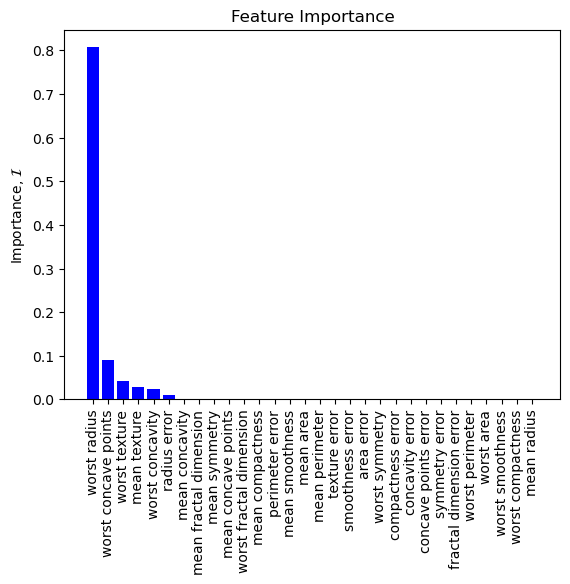

In [29]:
# Sorting features by on their importances,
idxs_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idxs_sorted]
feature_names_sorted = cancer_dataset.feature_names[idxs_sorted]

# Plotting,
fig, ax = plt.subplots()
ax.bar(feature_names_sorted, importances_sorted, color="blue")
ax.set_ylabel(r"Importance, $\mathcal{I}$")
ax.set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

As a final check, we can achieve the same results with the sci-kit learn implementation,

In [4]:
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier

# Creating and fitting tree,
sk_clf = SKDecisionTreeClassifier(max_depth=3, random_state=0)
sk_clf.fit(X_train, y_train)

# Computing importances,
sk_importances = sk_clf.feature_importances_
sk_importances

array([0.        , 0.02773047, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00985075, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.80678846, 0.04257079, 0.        , 0.        , 0.        ,
       0.        , 0.02295103, 0.0901085 , 0.        , 0.        ])

### References

https://www.youtube.com/watch?v=485x-rrH5Oc